<a href="https://colab.research.google.com/github/rachelszeto/Projects/blob/main/24F_Skin_tuition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fuzzywuzzy

In [ ]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Import Dataset

In [ ]:
# Load the dataset
products_link = 'https://drive.google.com/uc?id=1vVsijahx0gFduZsWaHu7UZ6GCQILfYIk'
products = pd.read_csv(products_link)

In [ ]:
# Check load correctly
products.head()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1


In [ ]:
# Load the Ingredient Functionality dataset
ingredients_link = 'https://drive.google.com/uc?id=1c7C6nqofNL6epIEWj3ACPHYsjAlwtndy'
ingredients = pd.read_csv(ingredients_link)

In [ ]:
#Clean up the 'Function' column in 'ingredients' to remove any "Incidecoder" mentions
ingredients['Function'] = ingredients['Function'].str.replace(r'(?i)\s*-\s*incidecoder', '', regex=True)
ingredients['Function'] = ingredients['Function'].str.replace(r'(?i)incidecoder', '', regex=True).str.strip()
ingredients.head()

,Function,Ingredient
0,Solvent,"1,10-Decanediol"
1,Solvent,"1,2-Butanediol"
2,Solvent,"1,2-Hexanediol"
3,Solvent,"1,4-Butanediol"
4,Solvent,"1,5-Pentanediol"


# Data Cleaning and Preprocessing

In [ ]:
# Check the Categories
products['Label'].unique()

array(['Moisturizer', 'Cleanser', 'Treatment', 'Face Mask', 'Eye cream',
       'Sun protect'], dtype=object)

In [ ]:
# Check for NaN Value
products.isna().sum()

,0
Label,0
Brand,0
Name,0
Price,0
Rank,0
Ingredients,0
Combination,0
Dry,0
Normal,0
Oily,0


In [ ]:
# Drop rows where 'ingredients are unknown
products = products[~products['Ingredients'].str.contains("Visit the", case=False, na=False)]
products = products[products['Ingredients'] != '#NAME?']
products.shape

(1348, 11)

In [ ]:
# Define a ingredient mapping
ingredient_mapping = {
    'Alge (Seweed) Extrct': 'Algae (Seaweed) Extract',
    'Mierl Oil': 'Mineral Oil',
    'Petroltum': 'Petrolatum',
    'Glyceri': 'Glycerin',
    'Isohexdece': 'Isohexadecane',
    'Microcrystllie Wx': 'Microcrystalline Wax',
    'Loli Alcohol': 'Lanolin Alcohol',
    'Citrus Aurtifoli (Lime) Extrct': 'Citrus Aurantifolia (Lime) Extract',
    'Sesmum Idicum (Sesame) Seed Oil': 'Sesamum Indicum (Sesame) Seed Oil',
    'Euclyptus Globulus (Eucalyptus) Lef Oil': 'Eucalyptus Globulus (Eucalyptus) Leaf Oil'
}

In [ ]:
# Standardize 'Ingredients' column in products
products['Ingredients'] = products['Ingredients'].astype(str).replace(ingredient_mapping).str.split(', ')

## Add Function for Each Ingredient

In [ ]:
# Explode the ingredients into separate rows
products_exploded = products.explode('Ingredients')

# Rename 'Ingredients' to 'ingredient'
products_exploded.rename(columns={'Ingredients': 'Ingredient'}, inplace=True)

products_exploded.head()

,Label,Brand,Name,Price,Rank,Ingredient,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Algae (Seaweed) Extract,1,1,1,1,1
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Mineral Oil,1,1,1,1,1
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Petrolatum,1,1,1,1,1
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Glycerin,1,1,1,1,1
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Isohexadecane,1,1,1,1,1


In [ ]:
# Create the Order column
products_exploded['Order'] = products_exploded.groupby(['Label', 'Brand', 'Name']).cumcount() + 1

In [ ]:
# Function to calculate percentile within each group
def calculate_percentile(group):
    max_rank = group['Order'].max()
    # Avoid division by zero when there's only one entry in the group
    if max_rank == 1:
        group['Percentile'] = 1  # Or set it to 0, depending on what you want
    else:
        group['Percentile'] = round(1 - (group['Order'] - 1) / (max_rank - 1), 2) * 100
    return group

In [ ]:
# Apply the function to each product
products_exploded = products_exploded.groupby('Name', group_keys=False).apply(calculate_percentile)

<ipython-input-16-4d23a06c9ecd>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  products_exploded = products_exploded.groupby('Name', group_keys=False).apply(calculate_percentile)


In [ ]:
# Clean ingredient names (lowercasing and removing special characters)
products_exploded['ingredient_clean'] = products_exploded['Ingredient'].str.lower().str.replace(r'\W', ' ')
ingredients['ingredient_clean'] = ingredients['Ingredient'].str.lower().str.replace(r'\W', ' ')

In [ ]:
# Concatenate the cleaned ingredients for both datasets while keeping their original indices
all_ingredients = pd.concat([ingredients['ingredient_clean'], products_exploded['ingredient_clean']], axis=0)

In [ ]:
# TF-IDF Vectorization for cosine similarity
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_ingredients)

In [ ]:
# Cosine similarity between ingredients in both datasets
cos_sim = cosine_similarity(tfidf_matrix[:len(ingredients)], tfidf_matrix[len(ingredients):])

In [ ]:
# Find best matches based on maximum cosine similarity
best_match_indices = cos_sim.argmax(axis=0)

In [ ]:
# Add functionality to the products_exploded dataset based on the best matches
products_exploded['Function'] = ingredients.iloc[best_match_indices]['Function'].values

In [ ]:
# Drop the 'ingredient_clean' column from products_exploded
products_exploded.drop(columns=['ingredient_clean'], inplace=True)

In [ ]:
# Define the desired column order
column_order = ['Label', 'Brand', 'Name', 'Price', 'Rank', 'Ingredient', 'Function', 'Combination',
                'Dry', 'Normal', 'Oily', 'Sensitive', 'Order', 'Percentile']

# Reorder the dataframe columns
products_exploded = products_exploded[column_order]

In [ ]:
# Inspect input accuracy
products_exploded.head()

,Label,Brand,Name,Price,Rank,Ingredient,Function,Combination,Dry,Normal,Oily,Sensitive,Order,Percentile
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Algae (Seaweed) Extract,Moisturizer/humectant,1,1,1,1,1,1,100.0
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Mineral Oil,Skin-identical ingredient,1,1,1,1,1,2,98.0
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Petrolatum,Solvent,1,1,1,1,1,3,95.0
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Glycerin,Skin-identical ingredient,1,1,1,1,1,4,93.0
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Isohexadecane,Solvent,1,1,1,1,1,5,90.0


## Active Ingredients Classification

### Active Ingredients:
Moisturizer/Humectant, Skin-identical ingredient, Sunscreen, Anti-acne, Cell-communicating ingredient, Skin brightening, Soothing, Exfoliant, Antioxidant
### Inactive Ingredients:
Emollient, Buffering, Emulsifying, Preservative, Antimicrobial/Antibacterial, Absorbent/Mattifier, Abrasive/Scrub, Chelating, Solvent, Perfuming, Viscosity controlling, Emulsion stabilizing, Colorant, Deodorant, Astringent, Surfactant/Cleansing

In [ ]:
# Define active functions
active_functions = ['Moisturizer/humectant', 'Skin-identical ingredient', 'Sunscreen',
                    'Anti-acne', 'Cell-communicating ingredient', 'Skin brightening',
                    'Soothing', 'Exfoliant', 'Antioxidant']

In [ ]:
# Add Active_Ingredient column
products_exploded['Active_Ingredient'] = products_exploded['Function'].apply(lambda x: 1 if x in active_functions else 0)

In [ ]:
products_exploded.head()

,Label,Brand,Name,Price,Rank,Ingredient,Function,Combination,Dry,Normal,Oily,Sensitive,Order,Percentile,Active_Ingredient
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Algae (Seaweed) Extract,Moisturizer/humectant,1,1,1,1,1,1,100.0,1
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Mineral Oil,Skin-identical ingredient,1,1,1,1,1,2,98.0,1
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Petrolatum,Solvent,1,1,1,1,1,3,95.0,0
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Glycerin,Skin-identical ingredient,1,1,1,1,1,4,93.0,1
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,Isohexadecane,Solvent,1,1,1,1,1,5,90.0,0


# Visualization

Temp color palette:
custom_colors = ['#f57c6e', '#f2b56f', '#fae69e', '#84c3b7', '#88d8db', '#71b7ed', '#b8aeeb', '#f2a7da']

In [ ]:
# Unify color palette
custom_colors = ['#f57c6e', '#f2b56f', '#fae69e', '#8bc34a', '#88d8db', '#71b7ed', '#b8aeeb', '#f2a7da']

In [ ]:
def standardize_percentile(df):
  # Group by 'Function' and aggregate the 'percentile' values by summing
  function_percentiles = df.groupby('Function')['Percentile'].sum()
  # Normalize by dividing each aggregated sum by the total sum and multiplying by 100 for percentage
  function_percentiles_normalized = (function_percentiles / function_percentiles.sum()) * 100
  return function_percentiles_normalized

In [ ]:
def specific_products(label):
    # Filter the dataset to include only the target label
    specific_product = products_exploded[products_exploded['Label'] == label]

    # Further filter to only include specific_product for specific skin type
    specific_product_dry = specific_product[(specific_product['Dry'] == 1) & (specific_product['Oily'] == 0) & (specific_product['Sensitive'] == 0) & (specific_product['Combination'] == 0)]
    specific_product_oily = specific_product[(specific_product['Oily'] == 1) & (specific_product['Dry'] == 0)& (specific_product['Sensitive'] == 0) & (specific_product['Combination'] == 0)]
    specific_product_sensitive = specific_product[(specific_product['Dry'] == 0) & (specific_product['Oily'] == 0) & (specific_product['Sensitive'] == 1) & (specific_product['Combination'] == 0)]
    specific_product_combination = specific_product[(specific_product['Dry'] == 0) & (specific_product['Oily'] == 0) & (specific_product['Sensitive'] == 0) & (specific_product['Combination'] == 1)]

    # Calculate the weights of each function
    dry_skin_functions = standardize_percentile(specific_product_dry)
    oily_skin_functions = standardize_percentile(specific_product_oily)
    sensitive_skin_functions = standardize_percentile(specific_product_sensitive)
    combination_skin_functions = standardize_percentile(specific_product_combination)

    # Combine into a single DataFrame for easier comparison
    comparison_df = pd.concat([
        dry_skin_functions.rename("Dry Skin"),
        oily_skin_functions.rename("Oily Skin"),
        sensitive_skin_functions.rename("Sensitive Skin"),
        combination_skin_functions.rename("Combination Skin")
    ], axis=1).fillna(0)

    # Reset index to make "Function" a column
    comparison_df.reset_index(inplace=True)
    comparison_df.rename(columns={'index': 'Function'}, inplace=True)

    # Define the custom order for 'Function' based on Active and Inactive Ingredients
    custom_order = [
        # Active Ingredients
        'Anti-acne', 'Antioxidant', 'Cell-communicating ingredient', 'Exfoliant',
        'Moisturizer/humectant', 'Skin brightening', 'Skin-identical ingredient',
        'Soothing', 'Sunscreen',

        # Inactive Ingredients
        'Abrasive/scrub', 'Absorbent/mattifier', 'Antimicrobial/antibacterial',
        'Astringent', 'Buffering', 'Chelating', 'Colorant', 'Deodorant', 'Emollient',
        'Emulsifying', 'Emulsion stabilising', 'Perfuming', 'Preservative',
        'Solvent', 'Surfactant/cleansing', 'Viscosity controlling'
    ]

    # Convert 'Function' column to a categorical type with the specified order
    comparison_df['Function'] = pd.Categorical(comparison_df['Function'], categories = custom_order, ordered = True)

    # Sort the DataFrame based on this custom order
    comparison_df = comparison_df.sort_values('Function').reset_index(drop=True)

    return comparison_df

In [ ]:
def compare_bar_plot(df, title, skin_type_list, color_list):
    # Create a Plotly figure
    fig = go.Figure()
    counter = 0

    for skin in skin_type_list:
        # Add traces for each skin type
        fig.add_trace(go.Bar(
            x = df['Function'],
            y = df[skin],
            name = skin,
            marker_color = color_list[counter]))
        counter += 1


    # Update layout to configure the chart
    fig.update_layout(
        title = title,
        title_x = 0.5,
        xaxis_title = "Ingredient Function",
        yaxis_title = "Percentage of Ingredients",
        barmode ='group',
        xaxis=dict(tickangle=45),
        legend_title="Skin Type")

    return fig

In [ ]:
moisturizers_comparison_df = specific_products('Moisturizer')

In [ ]:
compare_bar_plot(moisturizers_comparison_df,
                 "Proportion of Ingredient Functions in Moisturizers for Dry vs. Oily Skin", ['Oily Skin', 'Dry Skin'], ['#f57c6e', '#71b7ed'])

In [ ]:
treatments_comparison_df = specific_products('Treatment')

In [ ]:
compare_bar_plot(treatments_comparison_df,
                 "Proportion of Ingredient Functions in Treatments for Sensitive vs. Combination Skin", ['Sensitive Skin', 'Combination Skin'], ['#ffc107', '#8bc34a'])

In [ ]:
# Simulate the data
data_moisturizers = {
    'Function': [
        'Moisturizer/humectant', 'Skin brightening', 'Exfoliant',
        'Antioxidant', 'Soothing', 'Sunscreen'
    ],
    'Oily Skin': [30, 20, 10, 5, 25, 10],
    'Dry Skin': [40, 10, 5, 10, 30, 5]
}
moisturizers_comparison_df = pd.DataFrame(data_moisturizers)

data_treatments = {
    'Function': [
        'Anti-acne', 'Cell-communicating ingredient', 'Skin brightening',
        'Soothing', 'Astringent', 'Emollient'
    ],
    'Sensitive Skin': [10, 15, 5, 40, 10, 20],
    'Combination Skin': [20, 10, 15, 30, 10, 15]
}
treatments_comparison_df = pd.DataFrame(data_treatments)

# Define active and inactive functions
active_functions = [
    'Anti-acne', 'Antioxidant', 'Cell-communicating ingredient', 'Exfoliant',
    'Moisturizer/humectant', 'Skin brightening', 'Skin-identical ingredient',
    'Soothing', 'Sunscreen'
]
inactive_functions = [
    'Abrasive/scrub', 'Absorbent/mattifier', 'Antimicrobial/antibacterial',
    'Astringent', 'Buffering', 'Chelating', 'Colorant', 'Deodorant', 'Emollient',
    'Emulsifying', 'Emulsion stabilising', 'Perfuming', 'Preservative',
    'Solvent', 'Surfactant/cleansing', 'Viscosity controlling'
]

# Reorder functions
def reorder_functions_plotly(df):
    ordered_functions = active_functions + inactive_functions
    df['Function'] = pd.Categorical(df['Function'], categories=ordered_functions, ordered=True)
    return df.sort_values('Function').reset_index(drop=True)

moisturizers_comparison_df_ordered = reorder_functions_plotly(moisturizers_comparison_df.copy())
treatments_comparison_df_ordered = reorder_functions_plotly(treatments_comparison_df.copy())

# Create population pyramid
def create_population_pyramid(df, skin_types, title, color_list):
    df[skin_types[0]] = -df[skin_types[0]]  # Flip the first skin type for population pyramid

    fig = go.Figure()
    fig.add_trace(go.Bar(
        y=df['Function'],
        x=df[skin_types[0]],
        name=skin_types[0],
        orientation='h',
        marker_color=color_list[0]
    ))
    fig.add_trace(go.Bar(
        y=df['Function'],
        x=df[skin_types[1]],
        name=skin_types[1],
        orientation='h',
        marker_color=color_list[1]
    ))

    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,  # Center the title
            xanchor='center'  # Ensure proper centering
        ),
        barmode='overlay',
        xaxis=dict(
            title="Percentage of Ingredients",
            tickvals=[-50, -25, 0, 25, 50],
            ticktext=[50, 25, 0, 25, 50]
        ),
        yaxis=dict(title="Ingredient Function"),
        legend_title="Skin Type",
        plot_bgcolor="rgba(0, 0, 0, 0)"
    )
    return fig

    # Generate the pyramids
pyramid_moisturizers = create_population_pyramid(
    moisturizers_comparison_df_ordered,
    ['Oily Skin', 'Dry Skin'],
    "Population Pyramid: Ingredient Functions in Moisturizers (Ordered by Active & Inactive)",
    ['#f57c6e', '#71b7ed']
)

pyramid_treatments = create_population_pyramid(
    treatments_comparison_df_ordered,
    ['Sensitive Skin', 'Combination Skin'],
    "Population Pyramid: Ingredient Functions in Treatments (Ordered by Active & Inactive)",
    ['#ffc107', '#8bc34a']
)

# Show pyramids in Colab
pyramid_moisturizers.show()
pyramid_treatments.show()

### What are the most common skin types targeted by the popular beauty products, and how do they relate to the ingredients used? - Rachel

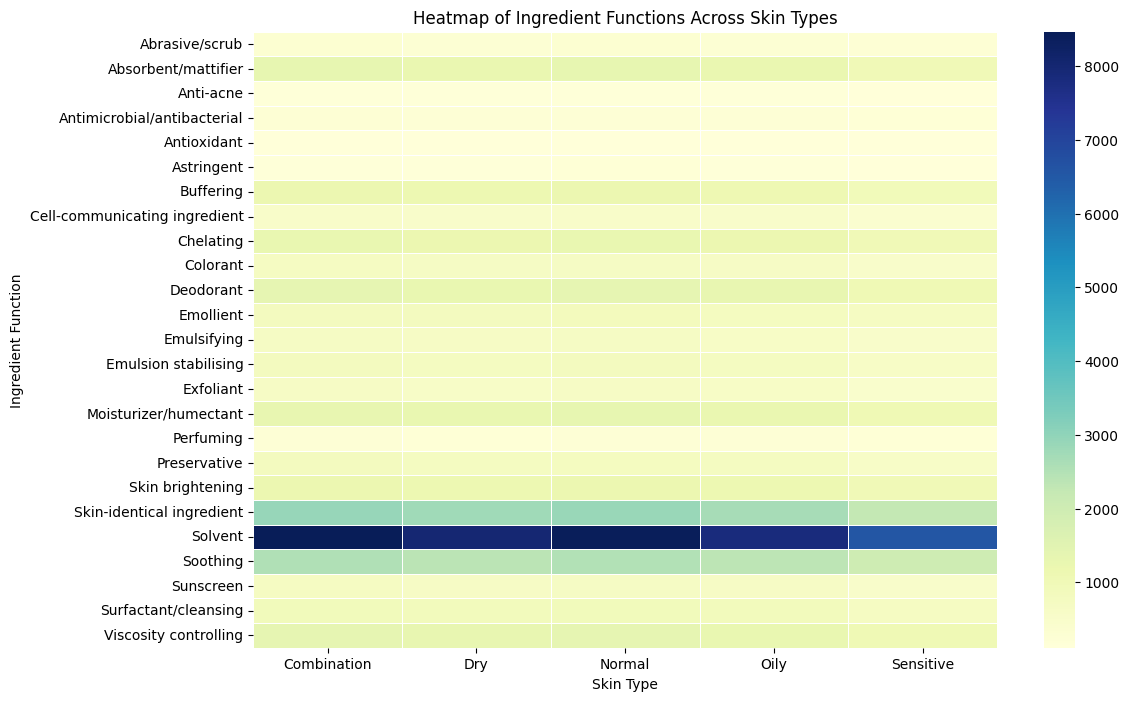

In [ ]:
# Heatmap of Ingredient Functions Across Skin Types
function_skin_type = products_exploded.groupby('Function')[['Combination', 'Dry', 'Normal', 'Oily', 'Sensitive']].sum()

plt.figure(figsize=(12, 8))
sns.heatmap(function_skin_type, cmap='YlGnBu', annot=False, linewidths=.5)
plt.title("Heatmap of Ingredient Functions Across Skin Types")
plt.xlabel("Skin Type")
plt.ylabel("Ingredient Function")
plt.show()

In [ ]:
# Distribution of Active Ingredients by Percentile Position
combination_active_ingredients = active_ingredients[active_ingredients['Combination'] == 1]

plt.figure(figsize=(10, 6))
sns.violinplot(data=combination_active_ingredients, x='Combination', y='Percentile', palette=custom_colors[:2])
plt.title("Distribution of Active Ingredients by Percentile Position (Combination Skin)")
plt.xlabel("Combination Skin Targeted (1 = Yes)")
plt.ylabel("Percentile Position")
plt.show()

NameError: name 'active_ingredients' is not defined

In [ ]:
# Filter the dataset to include only moisturizers
moisturizers = products_exploded[products_exploded['Label'] == 'Moisturizer']

In [ ]:
# Further filter to only include moisturizers for dry and oily skin
moisturizers_dry = moisturizers[(moisturizers['Dry'] == 1) & (moisturizers['Oily'] == 0)]
moisturizers_oily = moisturizers[(moisturizers['Oily'] == 1) & (moisturizers['Dry'] == 0)]

In [ ]:
def standardize_percentile(df):
  # Group by 'Function' and aggregate the 'percentile' values by summing
  function_percentiles = df.groupby('Function')['Percentile'].sum()
  # Normalize by dividing each aggregated sum by the total sum and multiplying by 100 for percentage
  function_percentiles_normalized = (function_percentiles / function_percentiles.sum()) * 100
  return function_percentiles_normalized

In [ ]:
# Calculate the weights of each function
dry_skin_functions = standardize_percentile(moisturizers_dry)
oily_skin_functions = standardize_percentile(moisturizers_oily)

In [ ]:
# Convert to percentage of total ingredients in each category
dry_skin_functions_percentage = (dry_skin_functions / dry_skin_functions.sum()) * 100
oily_skin_functions_percentage = (oily_skin_functions / oily_skin_functions.sum()) * 100

In [ ]:
# Combine into a single DataFrame for easier comparison
comparison_df = pd.DataFrame({
    'Dry Skin': dry_skin_functions,
    'Oily Skin': oily_skin_functions
}).fillna(0)

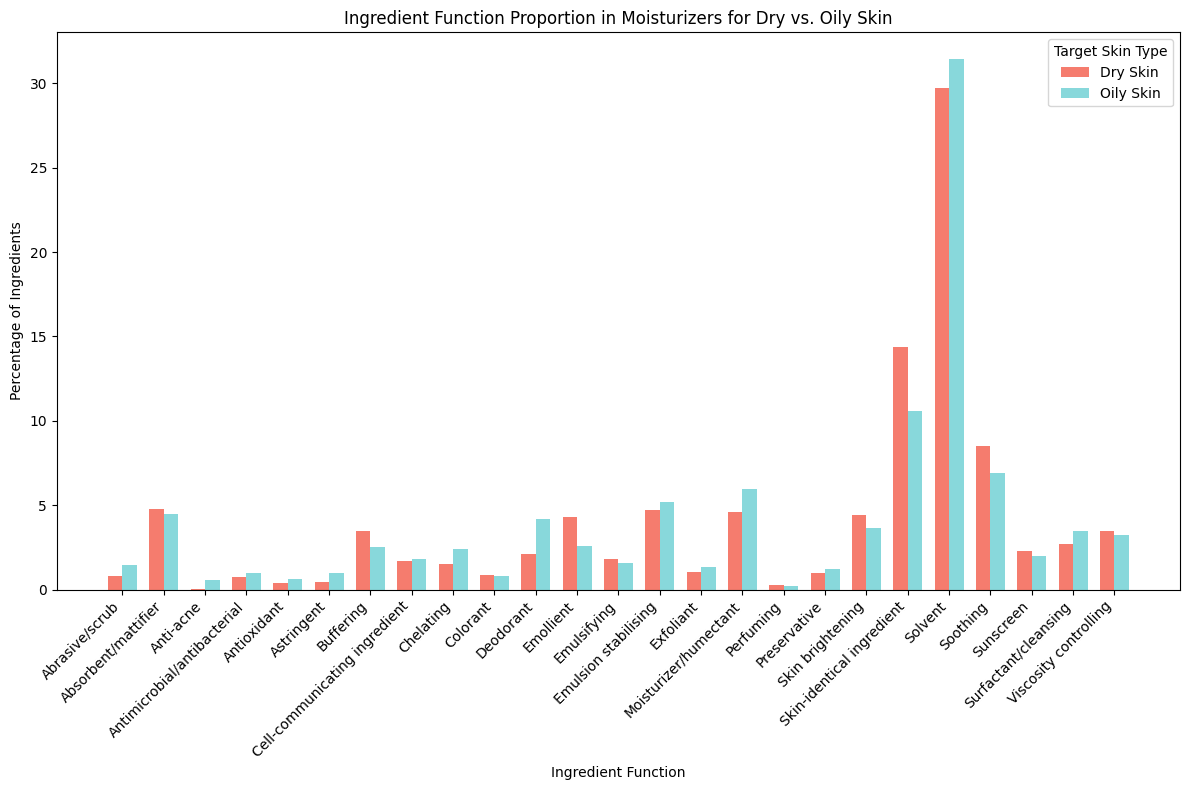

In [ ]:
# Plot
# Define bar width
bar_width = 0.35
index = np.arange(len(comparison_df))

# Plot side-by-side bars
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(index - bar_width/2, comparison_df['Dry Skin'], bar_width, label='Dry Skin', color='#f57c6e')
ax.bar(index + bar_width/2, comparison_df['Oily Skin'], bar_width, label='Oily Skin', color='#88d8db')

# Set labels, title, and legend
ax.set_xlabel('Ingredient Function')
ax.set_ylabel('Percentage of Ingredients')
ax.set_title('Ingredient Function Proportion in Moisturizers for Dry vs. Oily Skin')
ax.set_xticks(index)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend(title="Target Skin Type")

# Display the plot
plt.tight_layout()
plt.show()

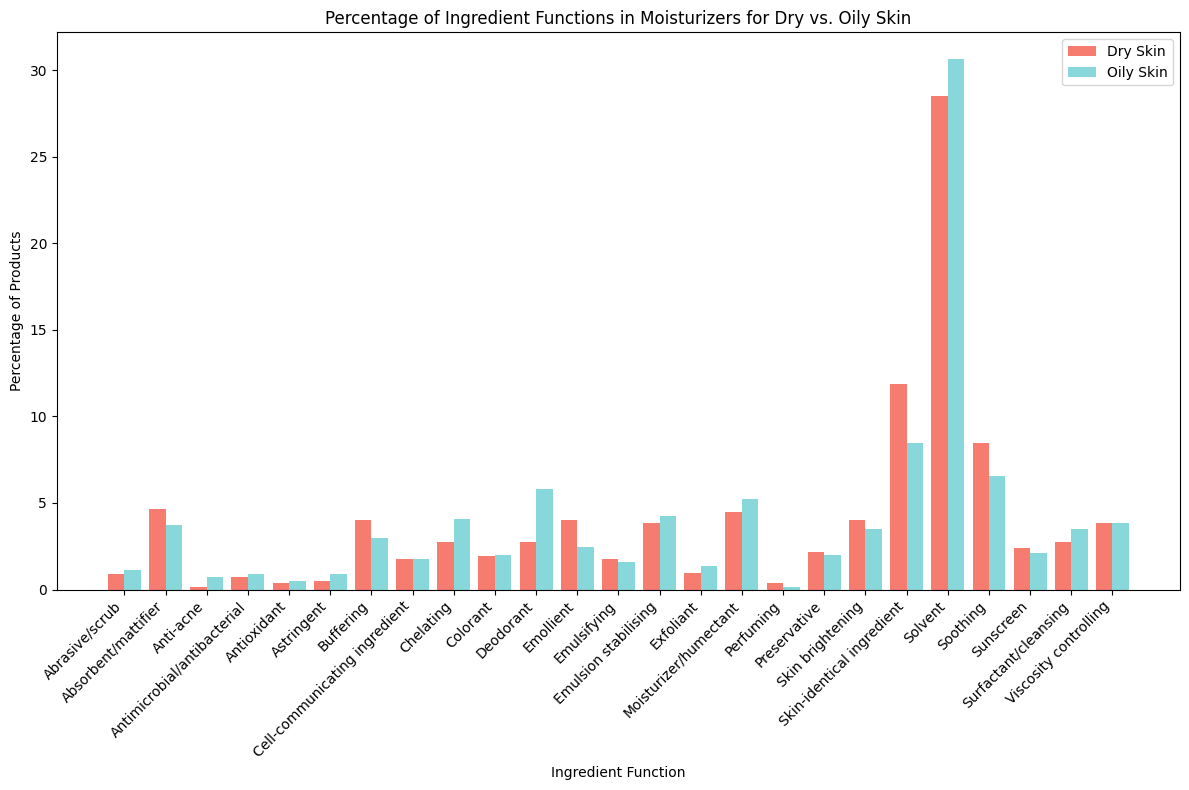

In [ ]:
# Calculate the total number of moisturizers for dry and oily skin
total_dry_moisturizers = len(moisturizers_dry)
total_oily_moisturizers = len(moisturizers_oily)

# Calculate the percentage for each function by dividing by the total product count
dry_skin_functions_percentage = (moisturizers_dry['Function'].value_counts() / total_dry_moisturizers) * 100
oily_skin_functions_percentage = (moisturizers_oily['Function'].value_counts() / total_oily_moisturizers) * 100

# Combine into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    'Dry Skin (%)': dry_skin_functions_percentage,
    'Oily Skin (%)': oily_skin_functions_percentage
}).fillna(0)

# Plot side-by-side for better comparison
fig, ax = plt.subplots(figsize=(12, 8))

# Plot dry and oily skin percentages side-by-side
bar_width = 0.4
index = np.arange(len(comparison_df))

# Bar plot for dry skin
ax.bar(index - bar_width/2, comparison_df['Dry Skin (%)'], bar_width, color='#f57c6e', label='Dry Skin')

# Bar plot for oily skin
ax.bar(index + bar_width/2, comparison_df['Oily Skin (%)'], bar_width, color='#88d8db', label='Oily Skin')

# Labels and title
ax.set_xlabel('Ingredient Function')
ax.set_ylabel('Percentage of Products')
ax.set_title('Percentage of Ingredient Functions in Moisturizers for Dry vs. Oily Skin')
ax.set_xticks(index)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

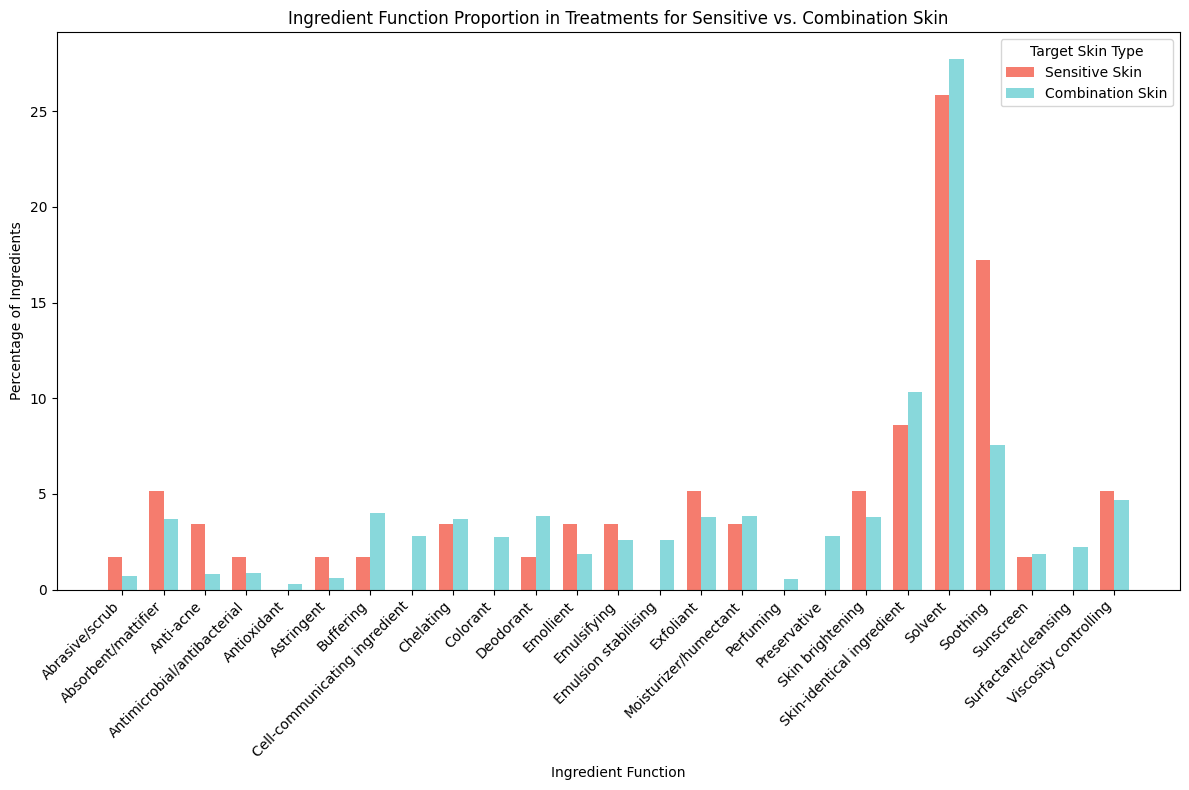

In [ ]:
# Filter the dataset to include only treatments
treatments = products_exploded[products_exploded['Label'] == 'Treatment']

# Further filter to only include treatments for sensitive and combination skin
treatments_sensitive = treatments[(treatments['Sensitive'] == 1) & (treatments['Combination'] == 0) ]
treatments_combination = treatments[treatments['Combination'] == 1 & (treatments['Sensitive'] == 0) ]

# Group by function and calculate frequency in each category for each skin type
sensitive_skin_functions = treatments_sensitive['Function'].value_counts(normalize=True) * 100
combination_skin_functions = treatments_combination['Function'].value_counts(normalize=True) * 100

# Convert to percentage of total ingredient functions in each category
sensitive_skin_functions_percentage = (sensitive_skin_functions / sensitive_skin_functions.sum()) * 100
combination_skin_functions_percentage = (combination_skin_functions / combination_skin_functions.sum()) * 100

# Combine into a single DataFrame for easier comparison
comparison_df = pd.DataFrame({
    'Sensitive Skin': sensitive_skin_functions,
    'Combination Skin': combination_skin_functions
}).fillna(0)

# Plot side-by-side bars
# Define bar width and positions
bar_width = 0.35
index = np.arange(len(comparison_df))

# Create a bar plot for the comparison
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(index - bar_width / 2, comparison_df['Sensitive Skin'], bar_width, label='Sensitive Skin', color='#f57c6e')
ax.bar(index + bar_width / 2, comparison_df['Combination Skin'], bar_width, label='Combination Skin', color='#88d8db')

# Set labels, title, and legend
ax.set_xlabel('Ingredient Function')
ax.set_ylabel('Percentage of Ingredients')
ax.set_title('Ingredient Function Proportion in Treatments for Sensitive vs. Combination Skin')
ax.set_xticks(index)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend(title="Target Skin Type")

# Display the plot
plt.tight_layout()
plt.show()

### What ingredients make the cost of the product more? - Olivia

In [ ]:
# Calculate the average price and average percentile position per ingredient and function
ingredient_summary = products_exploded.groupby(['Ingredient', 'Function', 'Label', 'Active_Ingredient']).agg(
    Avg_Price=('Price', 'mean'),
    Avg_Percentile=('Percentile', 'mean')
).reset_index().sort_values(by='Avg_Price', ascending=False)
ingredient_summary = ingredient_summary.reset_index(drop=True)
ingredient_summary = ingredient_summary[ingredient_summary['Active_Ingredient'] == 1]

In [ ]:
ingredient_summary['Scale'] = ingredient_summary['Avg_Price'] * (ingredient_summary['Avg_Percentile'] * 0.01)

In [ ]:
# ingredient_summary = ingredient_summary.head(100)
# ingredient_summary

In [ ]:
# Group by 'Function' to calculate the average price for each function and sort in descending order
function_summary = ingredient_summary.groupby('Function').agg(
    Avg_Function_Price=('Scale', 'mean')
).reset_index().sort_values(by='Avg_Function_Price', ascending=False)

# Create a bar plot
fig = px.bar(
    function_summary,
    x='Function',             # Functions along x-axis
    y='Avg_Function_Price',    # Average price of ingredients in each function
    text='Avg_Function_Price', # Show the average price as text on the bars
    color='Avg_Function_Price',          # Different colors for each function
    color_continuous_scale=custom_colors[::-1],  # Use the custom color palette
    labels={
        'Avg_Function_Price': 'Average Price($)',
        'Function': 'Ingredient Function'
    },
    title="Variation in Ingredient Prices by Ingredient Function",
)

# Customize for readability
fig.update_traces(
    texttemplate='$%{text:.2f}',
    textposition='outside',
    textfont=dict(family='Medium Sans', size=14),  # Adjust font size for bar text
    cliponaxis=False
)
fig.update_layout(
    title_x=0.5,
    title_font=dict(family='Medium Sans', size=22),  # Adjust title font size
    xaxis=dict(
        title_font=dict(family='Medium Sans', size=18),  # Adjust x-axis title font size
        tickfont=dict(family='Medium Sans', size=16),  # Adjust x-axis tick font size
        categoryorder='total descending'
    ),
    yaxis=dict(
        title_font=dict(family='Medium Sans', size=18),  # Adjust y-axis title font size
        tickfont=dict(family='Medium Sans', size=14)  # Adjust y-axis tick font size
    ),
    font=dict(family='Medium Sans', size=14),  # Global font adjustment
    showlegend=False,   # Hides the legend if colors are distinct enough
    width=1066.67,  # Set figure width
    height=600
)

# Display the plot
fig.show()

In [ ]:
def price_vs_percentile(df, color, facet):
  fig = px.scatter(
    df,
    x = 'Avg_Percentile',
    y = 'Avg_Price',
    color = color,
    facet_row = facet,
    color_discrete_sequence = custom_colors,
    labels={'Avg_Price': 'Average Price of Product With Ingredient ($)', 'Avg_Percentile': 'Average Percentile Position'},
    title='Ingredient Analysis: Average Price vs. Position in Product Formulations'
)

  # Customize the layout for readability
  #fig.update_traces(marker=dict(size=10, opacity=0.7))
  fig.update_layout(
    xaxis_title="Average Percentile Position (Lower percentile = higher concentration)",
    yaxis_title="Average Price of Product With Ingredient ($)")
  return fig

In [ ]:
price_vs_percentile(ingredient_summary, 'Label', 'Active_Ingredient')

In [ ]:
fig = px.box(ingredient_summary, x = 'Function', y = 'Scale', color = 'Function', facet_col = 'Active_Ingredient', color_discrete_sequence = custom_colors)
fig